<a href="https://colab.research.google.com/github/shauryanegi/tensorflow-deep-learning/blob/gh-pages/Transfer_Learning_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We've built a bunch of convolutional neural networks from scratch and they all seem to be learning, however, there is still plenty of room for improvement.

To improve our model(s), we could spend a while trying different configurations, adding more layers, changing the learning rate, adjusting the number of neurons per layer and more.

However, doing this is very time consuming.

Luckily, there's a technique we can use to save time.

It's called transfer learning, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:

Can leverage an existing neural network architecture proven to work on problems similar to our own.
Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.
What this means is, instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as ImageNet (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

Over the next few notebooks, we'll see the power of transfer learning in action.

In [ ]:
# Are we running a GPU?
!nvidia-smi

Sun Aug  1 11:27:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-08-01 11:27:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 142.250.107.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   278MB/s    in 0.6s    

2021-08-01 11:27:04 (278 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# How many images in each folder
import os

# Walk through 10% of the data directory and list the number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.'")

There are 2 directories and 0 images in '10_food_classes_10_percent'.'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.'
There are 0 directories and 75 images in '10_food_classes

## Creating some dataloaders (preparing the data)
 We will use ImageDataGenerator to load our images in batches

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")

print("Test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

Training images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training.
Some of the most popular callbacks are :

* Tracking experiments with the TensorBoard callback
* Model checkpointing with ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) is called the EarlyStopping

In [ ]:
# Create TensorBoard callback (functionaized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to :{log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

In [ ]:
# Let's compare the following two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficent_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, num_classes = 10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
  model_url(str): A TensorFlow Hub feature extraction URL.
  num_classes(int): Number of output neurons in the output layer,
  should be equal to the number of target classes, default 10.

  Returns:
  An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output later
  with num_classes output neurons
  """

  # Download the pretrained model and save it from Keras Layer.
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable= False, # freeze the already learned patterns
                                           name = "feature_extractor_layer",
                                           input_shape = IMAGE_SHAPE + (3,)) 
  
  # Create our model
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, 
                                            activation = 'softmax',
                                            name = 'output_layer')
  ])
  return model

## Creating and testing ResNet TensorFlow Hub Feature Extraction model


In [ ]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [ ]:
# Compile our model
resnet_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                     optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
                     metrics = ['accuracy'])

In [ ]:
# Fit our model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name= "tensorflow_hub",
                                                                           experiment_name = "restnet50v2")])

Saving TensorBoard log files to :tensorflow_hub/restnet50v2/20210801-113247
Epoch 1/5
24/24 [==============================] - 19s 812ms/step - loss: 1.8029 - accuracy: 0.6000 - val_loss: 1.2161 - val_accuracy: 0.7128
Epoch 2/5
24/24 [==============================] - 16s 677ms/step - loss: 0.5159 - accuracy: 0.8613 - val_loss: 0.9965 - val_accuracy: 0.7456
Epoch 3/5
24/24 [==============================] - 16s 669ms/step - loss: 0.1683 - accuracy: 0.9387 - val_loss: 0.8433 - val_accuracy: 0.7812
Epoch 4/5
24/24 [==============================] - 24s 1s/step - loss: 0.0660 - accuracy: 0.9800 - val_loss: 0.9204 - val_accuracy: 0.7728
Epoch 5/5
24/24 [==============================] - 16s 672ms/step - loss: 0.0308 - accuracy: 0.9947 - val_loss: 0.8348 - val_accuracy: 0.7860


In [ ]:
# Summary of the model
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________




Wow!

It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...with only 10 percent of the training images!

That goes to show the power of transfer learning. And it's one of the main reasons whenever you're trying to model your own datasets, you should look into what pretrained models already exist.

Let's check out our model's training curves using our plot_loss_curves function.


In [ ]:
# Let us create a function to plot loss curves
import matplotlib.pyplot as plt

# Plot the loss and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for accuracy and validation loss

  Args:
  history: TensorFlow History object

  Returns: Plots of training/validation loss and accuracy metrics

  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.style.use("ggplot")

  # Plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

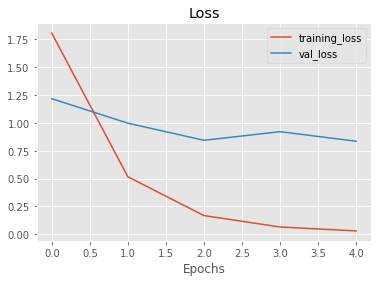

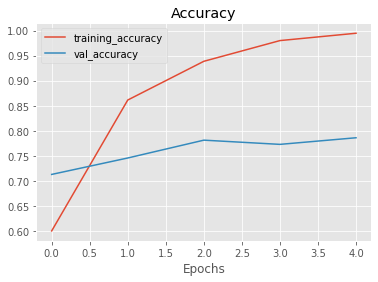

In [ ]:
# Plot loss curves of our trained model
plot_loss_curves(resnet_history)



You can see the power of TensorFlow Hub here. The feature extraction layer has 23,564,800 parameters which are prelearned patterns the model has already learned on the ImageNet dataset. Since we set trainable=False, these patterns remain frozen (non-trainable) during training.

This means during training the model updates the 20,490 parameters in the output layer to suit our dataset.

Okay, we've trained a ResNetV250 model, time to do the same with EfficientNetB0 model.

The setup will be the exact same as before, except for the model_url parameter in the create_model() function and the experiment_name parameter in the create_tensorboard_callback() function.


## Create model using EfficentNet model

In [ ]:
# Create EfficentNetB0 feature extractor model
efficentnet_model = create_model(model_url= efficent_url,
                                 num_classes = train_data_10_percent.num_classes)

# Compile EfficentNet model

efficentnet_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                          optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
                          metrics = ['accuracy'])
# Fit our model

efficentnet_history = efficentnet_model.fit(train_data_10_percent,
                                            epochs = 5,
                                            steps_per_epoch = len(train_data_10_percent),
                                            validation_data = test_data,
                                            validation_steps = len(test_data),
                                            callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                                     experiment_name = "efficentnetb0")])

Saving TensorBoard log files to :tensorflow_hub/efficentnetb0/20210801-115837
Epoch 1/5
24/24 [==============================] - 27s 820ms/step - loss: 0.9843 - accuracy: 0.6720 - val_loss: 0.4681 - val_accuracy: 0.8392
Epoch 2/5
24/24 [==============================] - 15s 644ms/step - loss: 0.2601 - accuracy: 0.9187 - val_loss: 0.4066 - val_accuracy: 0.8640
Epoch 3/5
24/24 [==============================] - 15s 640ms/step - loss: 0.1069 - accuracy: 0.9800 - val_loss: 0.4241 - val_accuracy: 0.8608
Epoch 4/5
24/24 [==============================] - 16s 676ms/step - loss: 0.0669 - accuracy: 0.9893 - val_loss: 0.4017 - val_accuracy: 0.8688
Epoch 5/5
24/24 [==============================] - 15s 668ms/step - loss: 0.0396 - accuracy: 0.9973 - val_loss: 0.3956 - val_accuracy: 0.8676


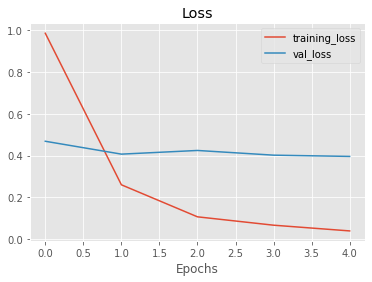

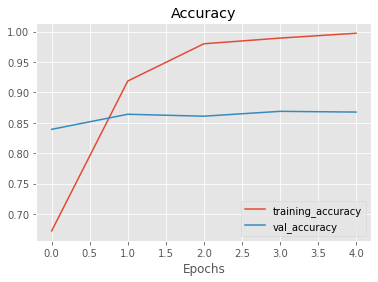

In [ ]:
# Plot loss curves of EfficentNet
plot_loss_curves(efficentnet_history)

In [ ]:
# Sumamry of model
efficentnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


It seems despite having over four times less parameters (4,049,564 vs. 23,564,800) than the ResNet50V2 extraction layer, the EfficientNetB0 feature extraction layer yields better performance. Now it's clear where the "efficient" name came from.

In [ ]:
# How many layers does our efficentnetb0 feature extractor have?
efficentnet_model.layers

## Comparing our models results using Tensorboard

Every time you upload something to TensorBoad.dev you'll get a new experiment ID. The experiment ID will look something like this: https://tensorboard.dev/experiment/73taSKxXQeGPQsNBcVvY3g/ (this is the actual experiment from this notebook).

If you upload the same directory again, you'll get a new experiment ID to go along with it.

This means to track your experiments, you may want to look into how you name your uploads. That way when you find them on TensorBoard.dev you can tell what happened during each experiment (e.g. "efficientnet0_10_percent_data")

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficentNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architecture using 10% of the training data" \
  --one_shot

2021-08-01 12:21:19.564480: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

In [ ]:
## Check out what TensorBoard experiments you have
#!tensorboard dev list